#0. Prerequisites

## 0.1 Setup and Data Download

In [ ]:
!pip install evaluate

In [ ]:
!pip install datasets

In [ ]:
!pip install accelerate -U

In [ ]:
# Requires a session restart if first time!
!python -m spacy download en_core_web_trf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 2.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!pip install emoji

In [ ]:
!pip install catboost

***NOTE! RESTART THE KERNEL AT LEAST ONCE BEFORE PROCEDING TO THE NEXT SECTION! THE INSTALLS REQUIRE A KERNEL RESTART!***

In [ ]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import string
import re
import nltk
import spacy
import emoji
import evaluate as ev
from gensim.models import Word2Vec
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from nltk.tokenize.casual import TweetTokenizer
from google.colab import data_table
from wordcloud import WordCloud
from catboost import CatBoostClassifier
from gensim.models import FastText
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from keras.initializers import Constant
from sklearn.utils.class_weight import compute_class_weight
from transformers import TrainingArguments, Trainer
from datasets import Dataset
from keras.layers import Dense, Embedding, LSTM, LayerNormalization, Dropout, GlobalMaxPooling1D
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Library Setup
_SEED = 42
keras.utils.set_random_seed(_SEED)
data_table.enable_dataframe_formatter()
nltk.download("wordnet")
nltk.download("punkt")
tqdm.pandas()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Extracting the .zip file
!unzip -o tweeteval.zip -d data

Archive:  tweeteval.zip
 extracting: data/mapping.txt        
 extracting: data/val_text.txt       
 extracting: data/test_labels.txt    
 extracting: data/train_labels.txt   
 extracting: data/test_text.txt      
 extracting: data/val_labels.txt     
 extracting: data/train_text.txt     


In [ ]:
# Creating the DataFrames. The data is preshuffled and presplit.
# We don't have to worry about splitting the data anymore.
X_train = pd.read_fwf("data/train_text.txt",   header = None, names = ['text'])
y_train = pd.read_fwf("data/train_labels.txt", header = None, names = ['label'])

X_val   = pd.read_fwf("data/val_text.txt",     header = None, names = ['text'])
y_val   = pd.read_fwf("data/val_labels.txt",   header = None, names = ['label'])

X_test  = pd.read_fwf("data/test_text.txt",    header = None, names = ['text'])
y_test  = pd.read_fwf("data/test_labels.txt",  header = None, names = ['label'])

mappings = pd.read_fwf("data/mapping.txt", header = None, names = ["id", "label"], sep = ' ')

In [ ]:
print(mappings)

   id     label
0   0     anger
1   1       joy
2   2  optimism
3   3   sadness


In [ ]:
X_train.head(50)

,text
0,“Worry is a down payment on a problem you may ...
1,My roommate: it's okay that we can't spell bec...
2,No but that's so cute. Atsu was probably shy a...
3,Rooneys fucking untouchable isn't he? Been fuc...
4,it's pretty depressing when u hit pan on ur fa...
5,@user but your pussy was weak from what I hear...
6,Making that yearly transition from excited and...
7,Tiller and breezy should do a collab album. Ra...
8,@user broadband is shocking regretting signing...
9,@user Look at those teef! #growl


## 0.2 Minor Cleanups

In [ ]:
# No missing values.
print(X_train.isnull().sum(), X_val.isnull().sum(), X_test.isnull().sum(), sep = '\n\n')

text    0
dtype: int64

text    0
dtype: int64

text    0
dtype: int64


In [ ]:
# Seems like there are some duplicates.
print(X_train.duplicated().sum(), X_val.duplicated().sum(), X_test.duplicated().sum(), sep = '\n\n')

25

0

0


In [ ]:
# Seems like a spam tweet. Let's remove this.
X_train[X_train.duplicated(keep = False)]

,text
176,Watch this amazing live.ly broadcast by @user ...
271,Watch this amazing live.ly broadcast by @user ...
435,Watch this amazing live.ly broadcast by @user ...
447,Watch this amazing live.ly broadcast by @user ...
581,Watch this amazing live.ly broadcast by @user ...
855,Watch this amazing live.ly broadcast by @user ...
882,Watch this amazing live.ly broadcast by @user ...
917,Watch this amazing live.ly broadcast by @user ...
1035,Watch this amazing live.ly broadcast by @user ...
1056,Watch this amazing live.ly broadcast by @user ...


In [ ]:
duplicated_indices = X_train[X_train.duplicated(keep = False)].index
print(duplicated_indices)

Index([ 176,  271,  435,  447,  581,  855,  882,  917, 1035, 1056, 1195, 1245,
       1251, 1254, 1263, 1282, 1434, 1538, 1694, 2113, 2189, 2329, 2483, 2513,
       2529, 2915, 3234],
      dtype='int64')


In [ ]:
X_train.drop(duplicated_indices, axis = "index", inplace = True)
y_train.drop(duplicated_indices, axis = "index", inplace = True)

# 1. Data Exploration

## 1.1 Exploration Preparation

In [ ]:
# Concatenating X_train and y_train for visualization.
df_train = pd.concat([X_train, y_train], axis = 1)
df_train.columns = np.array(["text", "label"])
df_train.head()

,text,label
0,“Worry is a down payment on a problem you may ...,2
1,My roommate: it's okay that we can't spell bec...,0
2,No but that's so cute. Atsu was probably shy a...,1
3,Rooneys fucking untouchable isn't he? Been fuc...,0
4,it's pretty depressing when u hit pan on ur fa...,3


In [ ]:
# Getting the proper id2label dictionary.
id2label = mappings.set_index('id').to_dict()['label']
print(id2label)

{0: 'anger', 1: 'joy', 2: 'optimism', 3: 'sadness'}


In [ ]:
# Remapping the class names.
df_train_mapped = df_train.copy()
df_train_mapped['label'] = df_train_mapped['label'].map(id2label)
df_train_mapped.head()

,text,label
0,“Worry is a down payment on a problem you may ...,optimism
1,My roommate: it's okay that we can't spell bec...,anger
2,No but that's so cute. Atsu was probably shy a...,joy
3,Rooneys fucking untouchable isn't he? Been fuc...,anger
4,it's pretty depressing when u hit pan on ur fa...,sadness


# 1.2 WordCloud Visualization

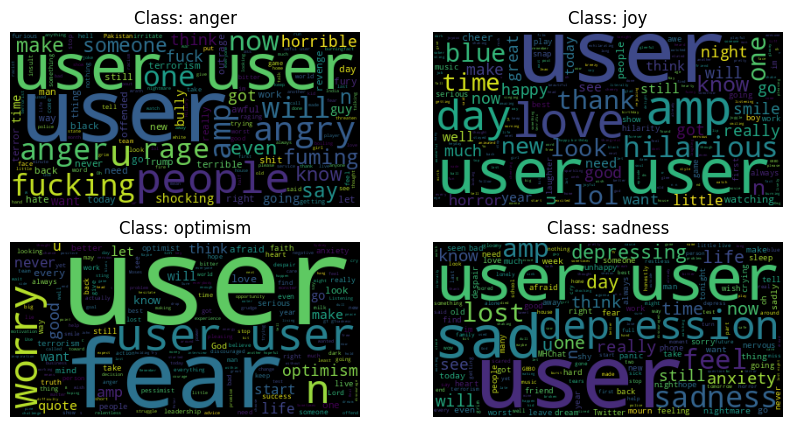

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (10, 5))
ax = ax.flatten()

for i, label in enumerate(np.unique(df_train_mapped['label'])):
  x = df_train_mapped[df_train_mapped['label'] == label]['text']
  fig = WordCloud().generate_from_text(' '.join(x))
  ax[i].imshow(fig)
  ax[i].axis("off")
  ax[i].set_title(f"Class: {label}")

Interesting results. We must remove the @'s since it shows up here. But why is fear and worry a part of the optimism class? Perhaps words such as "Don't worry!" and "Don't be afraid" occurs in the text. Stop word removal won't be good then.

## 1.3 Label Balance

<Axes: xlabel='label', ylabel='count'>

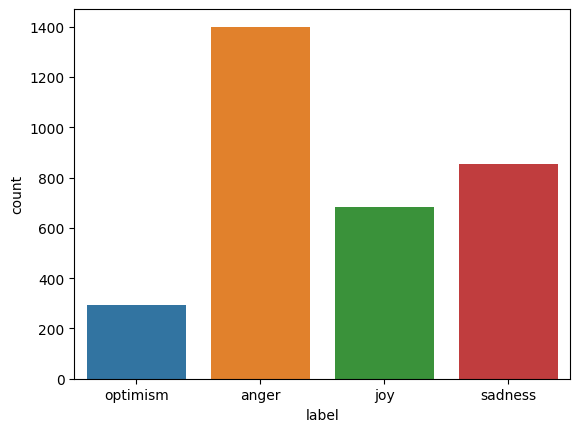

In [ ]:
sns.countplot(x = 'label', data=df_train_mapped, hue = 'label')

Oh when would text data be balanced? Well, seems like we must take into account the class weights.

# 2. Data Preprocessing

In [ ]:
_PRNT = set(string.printable)
_SPCY = spacy.load("en_core_web_trf", disable=["parser", "ner"])
_TKNZ = TweetTokenizer()

def clean(s):
  # Case folding.
  s = s.lower()

  # Remove unnecessary words.
  s = s.replace(r"\n", " ")
  s = s.replace("amp", " ")
  s = re.sub(r"\bu\b", "you", s)
  s = re.sub(r"\n\b", " ", s)

  # Replace improper glyphs
  s = s.replace(r"’", "'")

  # Removal of @s.
  s = re.sub(r"@\S*\s*", "", s)

  # De-emojize.
  s = emoji.demojize(s)

  # Removal of non-ASCII printables.
  p = set(string.printable)
  s = ''.join(filter(lambda w : w in p, s))

  # Lemmatization using Spacy.
  doc = _SPCY(s)
  s = [token.lemma_ for token in doc]

  # Rejoin and normalize.
  s = " ".join(s)
  s = " ".join(s.split())

  # Remove punctuations and symbols.
  s = s.translate(s.maketrans('', '', string.punctuation + string.digits))

  # Tokenize using TweetTokenizer.
  s = _TKNZ.tokenize(s)

  return s

In [ ]:
def clean_data(df):
  df_clean = df.copy()
  df_clean['clean_text'] = df_clean['text'].progress_apply(clean)
  return df_clean

In [ ]:
# Preparing clean ata
X_train_clean = clean_data(X_train)
X_val_clean   = clean_data(X_val)
X_test_clean  = clean_data(X_test)

100%|██████████| 1421/1421 [03:16<00:00,  7.23it/s]


In [ ]:
X_train_clean.head()

,text,clean_text
0,“Worry is a down payment on a problem you may ...,"[worry, be, a, down, payment, on, a, problem, ..."
1,My roommate: it's okay that we can't spell bec...,"[my, roommate, it, be, okay, that, we, can, no..."
2,No but that's so cute. Atsu was probably shy a...,"[no, but, that, be, so, cute, atsu, be, probab..."
3,Rooneys fucking untouchable isn't he? Been fuc...,"[rooney, fucking, untouchable, be, not, he, be..."
4,it's pretty depressing when u hit pan on ur fa...,"[it, be, pretty, depressing, when, you, hit, p..."


In [ ]:
# Maximum word length
_MAX = len(max(X_train_clean['clean_text'], key = len))
print(_MAX)

35


In [ ]:
# Average word length
_AVG = round(sum(len(x) for x in X_train_clean['clean_text'])/len(X_train_clean['clean_text']))
print(_AVG)

16


# 3. Text Representations


## 3.1 CountVectorizer (BoW)

In [ ]:
bow = CountVectorizer(lowercase = False, tokenizer = lambda x : x)
bow.fit(X_train_clean['clean_text'])
print(len(bow.vocabulary_))

def prepare_bow(x):
  x = bow.transform(x['clean_text'])
  x = pd.DataFrame(x.toarray())
  features = bow.get_feature_names_out()
  x.columns = features
  return x

X_train_bow = prepare_bow(X_train_clean)
X_val_bow = prepare_bow(X_val_clean)
X_test_bow = prepare_bow(X_test_clean)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


7169


In [ ]:
X_train_bow.head()

,Australia,I,a,aa,aaaaarrrrgghhh,aaahhhh,aaron,aarp,aateam,abandonment,...,zandu,zen,zero,zika,zionist,zionists,zombie,zone,zoolander,zzz
0,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3.2 TF-IDF

In [ ]:
tfidf = TfidfVectorizer(lowercase = False, tokenizer = lambda x : x)
tfidf.fit(X_train_clean['clean_text'])

def prepare_tfidf(df):
  return pd.DataFrame(tfidf.transform(df['clean_text']).toarray(), columns = tfidf.get_feature_names_out())

X_train_tfidf = prepare_tfidf(X_train_clean)
X_val_tfidf   = prepare_tfidf(X_val_clean)
X_test_tfidf  = prepare_tfidf(X_test_clean)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
X_train_tfidf.head()

,Australia,I,a,aa,aaaaarrrrgghhh,aaahhhh,aaron,aarp,aateam,abandonment,...,zandu,zen,zero,zika,zionist,zionists,zombie,zone,zoolander,zzz
0,0.0,0.0,0.18491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3.3 Word2Vec Skipgram (Avg. Row)

In [ ]:
_VECTOR_SIZE = 250
skipgram = Word2Vec(X_train_clean['clean_text'], min_count = 3, vector_size = _VECTOR_SIZE, window = _AVG, sg = 1)
_VOCAB_SKIPGRAM = set(skipgram.wv.index_to_key)

In [ ]:
def prepare_word2vec_row(df):
  word2vec_row = []
  for entry in df['clean_text']:
    word2vec_row.append(np.array([skipgram.wv.get_vector(word) for word in entry if word in _VOCAB_SKIPGRAM]))

  word2vec_row_avg = []
  for entry in word2vec_row:
    if (len(entry) != 0):
      word2vec_row_avg.append(entry.mean(axis = 0))
    else:
      word2vec_row_avg.append(np.zeros(_VECTOR_SIZE, dtype = float))

  return pd.DataFrame(word2vec_row_avg)

X_train_word2vec_row = prepare_word2vec_row(X_train_clean)
X_val_word2vec_row   = prepare_word2vec_row(X_val_clean)
X_test_word2vec_row  = prepare_word2vec_row(X_test_clean)*

In [ ]:
X_train_word2vec_row.head()

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,0.105640,0.050098,0.086001,-0.013082,-0.133914,-0.022185,0.024422,0.263109,-0.097284,0.030862,...,0.067607,-0.099220,-0.021218,0.140990,-0.017220,-0.075827,-0.100861,-0.118981,0.010611,0.074745
1,0.100399,0.040845,0.086614,-0.010012,-0.149092,-0.032870,0.004673,0.256577,-0.112882,0.033694,...,0.085552,-0.088557,-0.008503,0.165535,-0.004320,-0.091038,-0.113023,-0.129392,0.016892,0.073076
2,0.108791,0.040771,0.087237,-0.016039,-0.156100,-0.029232,0.029981,0.265866,-0.113109,0.025292,...,0.076658,-0.087339,-0.016922,0.160340,-0.003483,-0.079809,-0.087785,-0.136916,0.008873,0.066508
3,0.103787,0.050729,0.092573,-0.006190,-0.145568,-0.027631,0.023984,0.265502,-0.103722,0.037405,...,0.069729,-0.095200,-0.020172,0.159043,-0.016250,-0.073414,-0.105534,-0.128994,0.017528,0.073467
4,0.102463,0.044727,0.085018,-0.016076,-0.140200,-0.024281,0.011893,0.258859,-0.100678,0.031739,...,0.078109,-0.091140,-0.007841,0.150746,-0.003317,-0.081160,-0.102462,-0.118584,0.015910,0.074924


## 3.4 Word2Vec Skipgram (Avg. Column)

In [ ]:
def prepare_word2vec_column(x):
  word2vec_column = []
  for entry in x['clean_text']:
    word2vec_column.append(np.array([skipgram.wv.get_vector(word) for word in entry if word in _VOCAB_SKIPGRAM]))

  word2vec_column_avg = []
  for entry in word2vec_column:
    if (len(entry) <= 0):
      word2vec_column_avg.append(np.zeros(_MAX, dtype = float))
    else:
      v = entry.mean(axis = 1)
      if (len(v) < _MAX):
        v = np.pad(v, (0, _MAX-len(v)), 'constant', constant_values = 0)
        word2vec_column_avg.append(v)

  return pd.DataFrame(word2vec_column_avg)

X_train_word2vec_column = prepare_word2vec_column(X_train_clean)
X_val_word2vec_column   = prepare_word2vec_column(X_val_clean)
X_test_word2vec_column  = prepare_word2vec_column(X_test_clean)

In [ ]:
X_train_word2vec_column.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,0.002094,0.000728,-0.003122,-0.002788,-0.002592,-0.003122,-0.000879,0.002461,-0.001154,-0.000746,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.002041,-0.001118,0.003046,0.000728,-0.000101,0.002312,-0.001120,0.001004,0.006714,0.001203,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.001621,0.000719,0.002312,0.000728,-0.001824,-0.001076,0.000728,-0.000277,-0.000412,0.002896,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.001782,-0.001297,0.000728,0.006714,0.003845,0.000728,-0.001297,-0.000700,-0.001515,-0.000755,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.003046,0.000728,-0.001684,-0.001299,0.002794,0.002461,-0.000349,-0.002592,-0.000447,-0.001107,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3.5 Word2Vec Embedding Matrix

In [ ]:
_TOK = Tokenizer()
_TOK.fit_on_texts(X_train_clean['clean_text'])

In [ ]:
def tokenize_and_pad(x):
  x = _TOK.texts_to_sequences(x)
  x = pad_sequences(x, maxlen = _MAX, padding = 'post')
  return x

In [ ]:
word_to_vec = {}
for word in _VOCAB_SKIPGRAM:
  word_to_vec[word] = skipgram.wv.get_vector(word)

In [ ]:
_VOCAB_SIZE = len(_TOK.word_index) + 50
print(_VOCAB_SIZE)

7217


In [ ]:
word2vec_embedding = np.zeros((_VOCAB_SIZE, _VECTOR_SIZE))
for word, i in _TOK.word_index.items():
  v = word_to_vec.get(word)
  if v is not None:
    word2vec_embedding[i] = v

print(word2vec_embedding.shape)

(7217, 250)


## 3.5 FastText (Avg. Row)

In [ ]:
fasttext = FastText(vector_size = _VECTOR_SIZE, window = _AVG, min_count = 3, sentences = X_train_clean['clean_text'], epochs = 100)
_VOCAB_FASTTEXT = set(fasttext.wv.index_to_key)

In [ ]:
def prepare_fasttext_row(df):
  fasttext_row = []
  for entry in df['clean_text']:
    fasttext_row.append(np.array([fasttext.wv.get_vector(word) for word in entry if word in _VOCAB_FASTTEXT]))

  fasttext_row_avg = []
  for entry in fasttext_row:
    if (len(entry) != 0):
      fasttext_row_avg.append(entry.mean(axis = 0))
    else:
      fasttext_row_avg.append(np.zeros(_VECTOR_SIZE, dtype = float))

  return pd.DataFrame(fasttext_row_avg)

X_train_fasttext_row = prepare_fasttext_row(X_train_clean)
X_val_fasttext_row   = prepare_fasttext_row(X_val_clean)
X_test_fasttext_row  = prepare_fasttext_row(X_test_clean)

In [ ]:
X_train_fasttext_row.head()

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,-0.252047,-0.403006,-0.217443,-0.168641,-0.583214,0.280321,-0.029814,0.376849,0.234429,0.196393,...,-0.080276,-0.041310,0.671717,-0.362385,-0.624007,0.098976,-0.174309,0.263486,-0.522708,-0.261805
1,0.312002,-0.102371,-0.729620,-0.348365,-0.501056,0.155335,-0.168408,0.130043,0.225624,0.388446,...,-0.620515,0.529829,0.700277,0.207503,-0.436586,0.366428,0.292715,-0.340808,-0.497816,0.088629
2,0.162866,-0.326043,-0.442616,0.345268,-0.090637,-0.150838,0.454115,0.097249,-0.199610,0.555112,...,0.034618,0.316891,-0.010487,0.018461,-0.407880,0.389632,-0.340537,-0.080071,0.140073,0.204349
3,-0.489852,-0.266331,-0.074902,0.758774,-0.259815,0.233163,-0.064096,-0.024498,0.118012,0.897682,...,0.100713,0.142673,0.030490,0.562340,-0.521466,-0.361208,-0.325749,-0.304889,0.371359,-0.417993
4,-0.304773,0.200340,-0.934228,0.046961,-0.394568,0.038553,0.323971,-0.260416,0.121215,0.148700,...,0.020799,0.317519,0.044041,0.346096,-0.455728,0.365715,-0.191752,-0.421457,-0.167421,-0.076772


## 3.6 FastText (Avg. Column)

In [ ]:
def prepare_fasttext_column(x):
  fasttext_column = []
  for entry in x['clean_text']:
    fasttext_column.append(np.array([fasttext.wv.get_vector(word) for word in entry if word in _VOCAB_FASTTEXT]))

  fasttext_column_avg = []
  for entry in fasttext_column:
    if (len(entry) <= 0):
      fasttext_column_avg.append(np.zeros(_MAX, dtype = float))
    else:
      v = entry.mean(axis = 1)
      if (len(v) < _MAX):
        v = np.pad(v, (0, _MAX-len(v)), 'constant', constant_values = 0)
        fasttext_column_avg.append(v)

  return pd.DataFrame(fasttext_column_avg)

X_train_fasttext_column = prepare_fasttext_column(X_train_clean)
X_val_fasttext_column   = prepare_fasttext_column(X_val_clean)
X_test_fasttext_column  = prepare_fasttext_column(X_test_clean)

In [ ]:
X_train_fasttext_column.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,-0.023461,0.021226,-0.017410,-0.055211,0.025281,-0.017410,-0.006697,-0.070202,-0.037124,-0.024507,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.131104,0.027409,-0.030995,0.021226,-0.013496,-0.022499,0.018387,0.142179,0.077272,0.008629,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.128947,-0.100346,-0.022499,0.021226,-0.057748,0.016777,0.021226,0.051836,-0.055233,-0.061000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.020957,0.011925,0.021226,0.077272,-0.064562,0.021226,0.011925,-0.023419,0.084251,-0.027415,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.030995,0.021226,-0.009422,-0.010001,0.024371,-0.070202,-0.031623,0.025281,-0.067704,-0.030287,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3.7 FastText Embedding Matrix

In [ ]:
fast_to_vec = {}
for word in _VOCAB_FASTTEXT:
  fast_to_vec[word] = fasttext.wv.get_vector(word)

In [ ]:
fasttext_embedding = np.zeros((_VOCAB_SIZE, _VECTOR_SIZE))
for word, i in _TOK.word_index.items():
  v = word_to_vec.get(word)
  if v is not None:
    fasttext_embedding[i] = v

print(fasttext_embedding.shape)

(7217, 250)


# 4. Modelling

In [ ]:
def evaluate(y_true, y_pred):
  print(classification_report(y_true, y_pred, zero_division = 0))
  print(f1_score(y_true, y_pred, average = 'macro', zero_division = 0))

In [ ]:
def train_and_predict(model, train, test):
  model.fit(train, y_train['label'])
  return model.predict(test)

## 4.1 LinearSVM

### 4.1.1 LinearSVM + CountVectorizer

In [ ]:
linearsvm_bow = LinearSVC(class_weight = 'balanced')
evaluate(train_and_predict(linearsvm_bow, X_train_bow, X_test_bow), y_test['label'])

              precision    recall  f1-score   support

           0       0.75      0.75      0.75       555
           1       0.68      0.69      0.69       350
           2       0.41      0.35      0.38       141
           3       0.67      0.68      0.68       375

    accuracy                           0.68      1421
   macro avg       0.63      0.62      0.62      1421
weighted avg       0.68      0.68      0.68      1421

0.62317641914045


### 4.1.2 LinearSVM + TF-IDF

In [ ]:
linearsvm_tfidf = LinearSVC(class_weight = 'balanced')
evaluate(train_and_predict(linearsvm_tfidf, X_train_tfidf, X_test_tfidf), y_test['label'])

              precision    recall  f1-score   support

           0       0.79      0.74      0.76       602
           1       0.68      0.72      0.70       336
           2       0.43      0.39      0.41       136
           3       0.65      0.71      0.68       347

    accuracy                           0.69      1421
   macro avg       0.64      0.64      0.64      1421
weighted avg       0.70      0.69      0.69      1421

0.6377124851409544


### 4.1.3 LinearSVM + Word2Vec (Row)

In [ ]:
linearsvm_word2vec_row = LinearSVC(class_weight = 'balanced')
evaluate(train_and_predict(linearsvm_word2vec_row, X_train_word2vec_row, X_test_word2vec_row), y_test['label'])

              precision    recall  f1-score   support

           0       0.68      0.49      0.57       763
           1       0.26      0.48      0.34       191
           2       0.17      0.32      0.22        65
           3       0.43      0.41      0.42       402

    accuracy                           0.46      1421
   macro avg       0.38      0.43      0.39      1421
weighted avg       0.53      0.46      0.48      1421

0.38692653538879174


### 4.1.4 LinearSVM + Word2Vec (Column)

In [ ]:
linearsvm_word2vec_column = LinearSVC(class_weight = 'balanced')
evaluate(train_and_predict(linearsvm_word2vec_column, X_train_word2vec_column, X_test_word2vec_column), y_test['label'])

              precision    recall  f1-score   support

           0       1.00      0.39      0.56      1421
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.39      1421
   macro avg       0.25      0.10      0.14      1421
weighted avg       1.00      0.39      0.56      1421

0.14098029307731177


### 4.1.5 LinearSVM + FastText (Row)

In [ ]:
linearsvm_fasttext_row = LinearSVC(class_weight = 'balanced')
evaluate(train_and_predict(linearsvm_fasttext_row, X_train_fasttext_row, X_test_fasttext_row), y_test['label'])

              precision    recall  f1-score   support

           0       0.64      0.71      0.67       503
           1       0.62      0.62      0.62       357
           2       0.43      0.27      0.33       198
           3       0.58      0.61      0.60       363

    accuracy                           0.60      1421
   macro avg       0.57      0.55      0.56      1421
weighted avg       0.59      0.60      0.59      1421

0.555458007320749


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### 4.1.6 LinearSVM + FastText (Column)

In [ ]:
linearsvm_fasttext_column = LinearSVC(class_weight = 'balanced')
evaluate(train_and_predict(linearsvm_fasttext_column, X_train_fasttext_column, X_test_fasttext_column), y_test['label'])

              precision    recall  f1-score   support

           0       0.73      0.43      0.54       951
           1       0.06      0.28      0.10        78
           2       0.02      0.14      0.04        22
           3       0.30      0.31      0.30       370

    accuracy                           0.38      1421
   macro avg       0.28      0.29      0.25      1421
weighted avg       0.57      0.38      0.45      1421

0.2458982340004768


## 4.2 CatBoost

### 4.2.1 CatBoost + CountVectorizer

In [ ]:
catboost_bow = CatBoostClassifier(auto_class_weights = "Balanced")
evaluate(train_and_predict(catboost_bow, X_train_bow, X_test_bow), y_test['label'])

Learning rate set to 0.084003
0:	learn: 1.3789018	total: 100ms	remaining: 1m 39s
1:	learn: 1.3678913	total: 144ms	remaining: 1m 11s
2:	learn: 1.3637065	total: 184ms	remaining: 1m 1s
3:	learn: 1.3561524	total: 224ms	remaining: 55.7s
4:	learn: 1.3486670	total: 265ms	remaining: 52.8s
5:	learn: 1.3435919	total: 307ms	remaining: 50.8s
6:	learn: 1.3411341	total: 349ms	remaining: 49.5s
7:	learn: 1.3362152	total: 400ms	remaining: 49.6s
8:	learn: 1.3320053	total: 440ms	remaining: 48.4s
9:	learn: 1.3252253	total: 480ms	remaining: 47.5s
10:	learn: 1.3230935	total: 527ms	remaining: 47.4s
11:	learn: 1.3186158	total: 572ms	remaining: 47.1s
12:	learn: 1.3164405	total: 615ms	remaining: 46.7s
13:	learn: 1.3117885	total: 658ms	remaining: 46.3s
14:	learn: 1.3089393	total: 718ms	remaining: 47.1s
15:	learn: 1.3053002	total: 787ms	remaining: 48.4s
16:	learn: 1.3032359	total: 867ms	remaining: 50.2s
17:	learn: 1.3013407	total: 939ms	remaining: 51.2s
18:	learn: 1.2956961	total: 1.02s	remaining: 52.6s
19:	learn

### 4.2.2 CatBoost + TF-IDF

In [ ]:
catboost_tfidf = CatBoostClassifier(auto_class_weights = "Balanced")
evaluate(train_and_predict(catboost_tfidf, X_train_tfidf, X_test_tfidf), y_test['label'])

Learning rate set to 0.084003
0:	learn: 1.3770754	total: 188ms	remaining: 3m 8s
1:	learn: 1.3682677	total: 311ms	remaining: 2m 35s
2:	learn: 1.3633537	total: 437ms	remaining: 2m 25s
3:	learn: 1.3555406	total: 576ms	remaining: 2m 23s
4:	learn: 1.3489703	total: 710ms	remaining: 2m 21s
5:	learn: 1.3436298	total: 844ms	remaining: 2m 19s
6:	learn: 1.3387482	total: 970ms	remaining: 2m 17s
7:	learn: 1.3347200	total: 1.09s	remaining: 2m 15s
8:	learn: 1.3283264	total: 1.22s	remaining: 2m 14s
9:	learn: 1.3213895	total: 1.35s	remaining: 2m 14s
10:	learn: 1.3144247	total: 1.5s	remaining: 2m 14s
11:	learn: 1.3099869	total: 1.63s	remaining: 2m 13s
12:	learn: 1.3063101	total: 1.75s	remaining: 2m 13s
13:	learn: 1.3028570	total: 1.89s	remaining: 2m 13s
14:	learn: 1.2976104	total: 2.04s	remaining: 2m 13s
15:	learn: 1.2931303	total: 2.17s	remaining: 2m 13s
16:	learn: 1.2903412	total: 2.29s	remaining: 2m 12s
17:	learn: 1.2859546	total: 2.42s	remaining: 2m 11s
18:	learn: 1.2818783	total: 2.55s	remaining: 2

### 4.2.3 CatBoost + Word2Vec (Row)

In [ ]:
catboost_word2vec_row = CatBoostClassifier(auto_class_weights = "Balanced")
evaluate(train_and_predict(catboost_word2vec_row, X_train_word2vec_row, X_test_word2vec_row), y_test['label'])

Learning rate set to 0.084003
0:	learn: 1.3750924	total: 268ms	remaining: 4m 27s
1:	learn: 1.3654908	total: 455ms	remaining: 3m 46s
2:	learn: 1.3571233	total: 650ms	remaining: 3m 35s
3:	learn: 1.3504063	total: 835ms	remaining: 3m 27s
4:	learn: 1.3444778	total: 1.01s	remaining: 3m 21s
5:	learn: 1.3373817	total: 1.19s	remaining: 3m 16s
6:	learn: 1.3317803	total: 1.36s	remaining: 3m 13s
7:	learn: 1.3245205	total: 1.53s	remaining: 3m 9s
8:	learn: 1.3156001	total: 1.72s	remaining: 3m 9s
9:	learn: 1.3092704	total: 1.9s	remaining: 3m 7s
10:	learn: 1.3019879	total: 2.07s	remaining: 3m 5s
11:	learn: 1.2968084	total: 2.23s	remaining: 3m 3s
12:	learn: 1.2898200	total: 2.45s	remaining: 3m 6s
13:	learn: 1.2846997	total: 2.63s	remaining: 3m 5s
14:	learn: 1.2812685	total: 2.82s	remaining: 3m 5s
15:	learn: 1.2746099	total: 2.98s	remaining: 3m 3s
16:	learn: 1.2697049	total: 3.16s	remaining: 3m 2s
17:	learn: 1.2647647	total: 3.33s	remaining: 3m 1s
18:	learn: 1.2586094	total: 3.5s	remaining: 3m
19:	learn

### 4.2.4 CatBoost + Word2Vec (Column)

In [ ]:
catboost_word2vec_column = CatBoostClassifier(auto_class_weights = "Balanced")
evaluate(train_and_predict(catboost_word2vec_column, X_train_word2vec_column, X_test_word2vec_column), y_test['label'])

Learning rate set to 0.084003
0:	learn: 1.3818932	total: 35.8ms	remaining: 35.7s
1:	learn: 1.3783396	total: 66.7ms	remaining: 33.3s
2:	learn: 1.3754818	total: 96ms	remaining: 31.9s
3:	learn: 1.3714008	total: 129ms	remaining: 32s
4:	learn: 1.3674750	total: 153ms	remaining: 30.4s
5:	learn: 1.3643934	total: 187ms	remaining: 31s
6:	learn: 1.3617309	total: 216ms	remaining: 30.7s
7:	learn: 1.3575082	total: 233ms	remaining: 28.9s
8:	learn: 1.3543407	total: 250ms	remaining: 27.5s
9:	learn: 1.3498581	total: 266ms	remaining: 26.4s
10:	learn: 1.3471542	total: 285ms	remaining: 25.6s
11:	learn: 1.3447266	total: 302ms	remaining: 24.9s
12:	learn: 1.3425967	total: 319ms	remaining: 24.2s
13:	learn: 1.3395804	total: 335ms	remaining: 23.6s
14:	learn: 1.3361501	total: 352ms	remaining: 23.1s
15:	learn: 1.3310861	total: 369ms	remaining: 22.7s
16:	learn: 1.3286620	total: 387ms	remaining: 22.4s
17:	learn: 1.3258322	total: 404ms	remaining: 22s
18:	learn: 1.3248114	total: 423ms	remaining: 21.8s
19:	learn: 1.323

### 4.2.5 CatBoost + FastText (Row)


In [ ]:
catboost_fasttext_row = CatBoostClassifier(auto_class_weights = "Balanced")
evaluate(train_and_predict(catboost_fasttext_row, X_train_fasttext_row, X_test_fasttext_row), y_test['label'])

Learning rate set to 0.084003
0:	learn: 1.3749124	total: 251ms	remaining: 4m 10s
1:	learn: 1.3572176	total: 441ms	remaining: 3m 40s
2:	learn: 1.3447752	total: 618ms	remaining: 3m 25s
3:	learn: 1.3341625	total: 790ms	remaining: 3m 16s
4:	learn: 1.3255199	total: 965ms	remaining: 3m 11s
5:	learn: 1.3131741	total: 1.14s	remaining: 3m 8s
6:	learn: 1.3012041	total: 1.31s	remaining: 3m 6s
7:	learn: 1.2917213	total: 1.5s	remaining: 3m 5s
8:	learn: 1.2827473	total: 1.67s	remaining: 3m 4s
9:	learn: 1.2747718	total: 1.85s	remaining: 3m 3s
10:	learn: 1.2642028	total: 2.03s	remaining: 3m 2s
11:	learn: 1.2543275	total: 2.2s	remaining: 3m 1s
12:	learn: 1.2454047	total: 2.41s	remaining: 3m 3s
13:	learn: 1.2348383	total: 2.59s	remaining: 3m 2s
14:	learn: 1.2281243	total: 2.76s	remaining: 3m 1s
15:	learn: 1.2195246	total: 2.93s	remaining: 3m
16:	learn: 1.2105036	total: 3.11s	remaining: 2m 59s
17:	learn: 1.2029004	total: 3.27s	remaining: 2m 58s
18:	learn: 1.1974922	total: 3.46s	remaining: 2m 58s
19:	lear

### 4.2.6 CatBoost + FastText (Column)

In [ ]:
catboost_fasttext_column = CatBoostClassifier(auto_class_weights = "Balanced")
evaluate(train_and_predict(catboost_fasttext_column, X_train_fasttext_column, X_test_fasttext_column), y_test['label'])

Learning rate set to 0.084003
0:	learn: 1.3840420	total: 26.9ms	remaining: 26.8s
1:	learn: 1.3789020	total: 46.6ms	remaining: 23.3s
2:	learn: 1.3750420	total: 65.4ms	remaining: 21.7s
3:	learn: 1.3737768	total: 82.4ms	remaining: 20.5s
4:	learn: 1.3714341	total: 101ms	remaining: 20.1s
5:	learn: 1.3673135	total: 118ms	remaining: 19.6s
6:	learn: 1.3632916	total: 135ms	remaining: 19.2s
7:	learn: 1.3606429	total: 152ms	remaining: 18.9s
8:	learn: 1.3586616	total: 169ms	remaining: 18.6s
9:	learn: 1.3561382	total: 187ms	remaining: 18.5s
10:	learn: 1.3532781	total: 207ms	remaining: 18.6s
11:	learn: 1.3505731	total: 225ms	remaining: 18.5s
12:	learn: 1.3472823	total: 241ms	remaining: 18.3s
13:	learn: 1.3433779	total: 258ms	remaining: 18.2s
14:	learn: 1.3406046	total: 275ms	remaining: 18s
15:	learn: 1.3365732	total: 292ms	remaining: 18s
16:	learn: 1.3347188	total: 311ms	remaining: 18s
17:	learn: 1.3311256	total: 328ms	remaining: 17.9s
18:	learn: 1.3254133	total: 345ms	remaining: 17.8s
19:	learn: 1.

## 4.3 LSTM

In [ ]:
# Class weights
CW_ = dict(enumerate(compute_class_weight(class_weight = "balanced", classes = np.unique(y_train['label']), y = y_train['label'])))
CW_

{0: 0.5767857142857142,
 1: 1.1857562408223201,
 2: 2.746598639455782,
 3: 0.9444444444444444}

### 4.3.1 LSTM + Word2Vec Embeddings

In [ ]:
model_lstm_word2vec = keras.Sequential(
    [
      #Embedding Block
      Embedding(
          input_dim = _VOCAB_SIZE,
          output_dim = _VECTOR_SIZE,
          input_length = _MAX,
          weights = [word2vec_embedding],
          mask_zero = True,
          trainable = False
      ),
      #LSTM Block
      LSTM(_MAX, return_sequences = True),
      LayerNormalization(),
      LSTM(_MAX, return_sequences = True),
      LayerNormalization(),
      LSTM(_MAX, return_sequences = True),
      LayerNormalization(),

      #Dense Head
      GlobalMaxPooling1D(),
      Dense(16, 'relu'),
      Dropout(0.3),
      Dense(4, 'softmax')
    ]
)

print(model_lstm_word2vec.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 250)           1804250   
                                                                 
 lstm (LSTM)                 (None, 35, 35)            40040     
                                                                 
 layer_normalization (Layer  (None, 35, 35)            70        
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 35, 35)            9940      
                                                                 
 layer_normalization_1 (Lay  (None, 35, 35)            70        
 erNormalization)                                                
                                                                 
 lstm_2 (LSTM)               (None, 35, 35)            9

In [ ]:
callback = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    restore_best_weights = True
)

In [ ]:
model_lstm_word2vec.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.AdamW(),
    metrics=["accuracy"],
)

In [ ]:
lstm_word2vec_history = model_lstm_word2vec.fit(
  tokenize_and_pad(X_train_clean['clean_text']),
  y_train['label'],
  validation_data = (tokenize_and_pad(X_val_clean['clean_text']), y_val['label']),
  batch_size = 128,
  epochs = 100,
  class_weight = CW_,
  callbacks = [callback]
)

Epoch 1/100
26/26 [==============================] - 21s 186ms/step - loss: 1.4714 - accuracy: 0.2650 - val_loss: 1.3608 - val_accuracy: 0.3957
Epoch 2/100
26/26 [==============================] - 1s 21ms/step - loss: 1.3906 - accuracy: 0.3331 - val_loss: 1.3808 - val_accuracy: 0.3075
Epoch 3/100
26/26 [==============================] - 1s 22ms/step - loss: 1.3862 - accuracy: 0.2947 - val_loss: 1.3867 - val_accuracy: 0.2861
Epoch 4/100
26/26 [==============================] - 1s 22ms/step - loss: 1.3861 - accuracy: 0.2378 - val_loss: 1.3921 - val_accuracy: 0.2219
Epoch 5/100
26/26 [==============================] - 1s 21ms/step - loss: 1.3835 - accuracy: 0.2517 - val_loss: 1.3779 - val_accuracy: 0.2834
Epoch 6/100
26/26 [==============================] - 1s 20ms/step - loss: 1.3813 - accuracy: 0.2808 - val_loss: 1.3857 - val_accuracy: 0.1604
Epoch 7/100
26/26 [==============================] - 1s 21ms/step - loss: 1.3824 - accuracy: 0.2334 - val_loss: 1.3702 - val_accuracy: 0.3930
Epoc

In [ ]:
y_pred = np.argmax(model_lstm_word2vec.predict(tokenize_and_pad(X_test_clean['clean_text'])), axis = 1)
evaluate(y_pred, y_test['label'])

45/45 [==============================] - 4s 7ms/step
              precision    recall  f1-score   support

           0       0.91      0.41      0.56      1247
           1       0.01      0.27      0.02        11
           2       0.00      0.00      0.00         3
           3       0.10      0.24      0.14       160

    accuracy                           0.39      1421
   macro avg       0.25      0.23      0.18      1421
weighted avg       0.81      0.39      0.51      1421

0.18048611372540319


Really terrible. Underfitting due to word embedding quality? Word2Vec and FastText seems terrible with small vocabulary inputs.

### 4.3.2 LSTM + FastText Embeddings

In [ ]:
model_lstm_fasttext = keras.Sequential(
    [
      #Embedding Block
      Embedding(
          input_dim = _VOCAB_SIZE,
          output_dim = _VECTOR_SIZE,
          input_length = _MAX,
          weights = [fasttext_embedding],
          mask_zero = True,
          trainable = False
      ),
      #LSTM Block
      LSTM(_MAX, return_sequences = True),
      LayerNormalization(),
      LSTM(_MAX, return_sequences = True),
      LayerNormalization(),
      LSTM(_MAX, return_sequences = True),
      LayerNormalization(),

      #Dense Head
      GlobalMaxPooling1D(),
      Dense(32, 'relu'),
      Dropout(0.1),
      Dense(4, 'sigmoid')
    ]
)

print(model_lstm_fasttext.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 35, 250)           1804250   
                                                                 
 lstm_3 (LSTM)               (None, 35, 35)            40040     
                                                                 
 layer_normalization_3 (Lay  (None, 35, 35)            70        
 erNormalization)                                                
                                                                 
 lstm_4 (LSTM)               (None, 35, 35)            9940      
                                                                 
 layer_normalization_4 (Lay  (None, 35, 35)            70        
 erNormalization)                                                
                                                                 
 lstm_5 (LSTM)               (None, 35, 35)           

In [ ]:
model_lstm_fasttext.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.AdamW(),
    metrics=["accuracy"],
)

In [ ]:
lstm_fasttext_history = model_lstm_word2vec.fit(
  tokenize_and_pad(X_train_clean['clean_text']),
  y_train['label'],
  validation_data = (tokenize_and_pad(X_val_clean['clean_text']), y_val['label']),
  batch_size = 128,
  epochs = 100,
  class_weight = CW_,
  callbacks = [callback]
)

Epoch 1/100
26/26 [==============================] - 1s 24ms/step - loss: 1.3897 - accuracy: 0.2833 - val_loss: 1.3674 - val_accuracy: 0.3449
Epoch 2/100
26/26 [==============================] - 1s 23ms/step - loss: 1.3844 - accuracy: 0.2892 - val_loss: 1.3746 - val_accuracy: 0.3770
Epoch 3/100
26/26 [==============================] - 1s 20ms/step - loss: 1.3812 - accuracy: 0.3006 - val_loss: 1.3786 - val_accuracy: 0.2647
Epoch 4/100
26/26 [==============================] - 1s 23ms/step - loss: 1.3789 - accuracy: 0.2331 - val_loss: 1.3714 - val_accuracy: 0.3396
Epoch 5/100
26/26 [==============================] - 1s 21ms/step - loss: 1.3744 - accuracy: 0.2975 - val_loss: 1.3753 - val_accuracy: 0.2647
Epoch 6/100
26/26 [==============================] - 1s 20ms/step - loss: 1.3651 - accuracy: 0.3176 - val_loss: 1.3981 - val_accuracy: 0.1578
Epoch 7/100
26/26 [==============================] - 1s 21ms/step - loss: 1.3739 - accuracy: 0.2384 - val_loss: 1.3846 - val_accuracy: 0.2460
Epoch 

In [ ]:
y_pred = np.argmax(model_lstm_fasttext.predict(tokenize_and_pad(X_test_clean['clean_text'])), axis = 1)
evaluate(y_pred, y_test['label'])

45/45 [==============================] - 4s 7ms/step
              precision    recall  f1-score   support

           0       0.96      0.40      0.56      1342
           1       0.08      0.41      0.14        73
           2       0.00      0.00      0.00         0
           3       0.01      0.33      0.01         6

    accuracy                           0.40      1421
   macro avg       0.26      0.29      0.18      1421
weighted avg       0.91      0.40      0.54      1421

0.17764326170510347


One of the worst case of underfitting I've ever seen. Possibly due to the lack of quality word embeddings....

## 4.4 Extra: Pretrained RoBERTa on Twitter

In [ ]:
roberta_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-2022-154m", add_prefix_space=True)
roberta_model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-2022-154m", num_labels = 4)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-2022-154m and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Preparing the datasets.
df_train = pd.concat([X_train_clean['clean_text'], y_train['label']], axis = 1)
df_val   = pd.concat([X_val_clean['clean_text'], y_val['label']], axis = 1)
df_test  = pd.concat([X_test_clean['clean_text'], y_test['label']], axis = 1)

In [ ]:
# Converting to proper dataset form.
ds_train = Dataset.from_pandas(df_train, preserve_index = False)
ds_val = Dataset.from_pandas(df_val, preserve_index = False)
ds_test = Dataset.from_pandas(df_test, preserve_index = False)

In [ ]:
def tokenize(x):
    return roberta_tokenizer(x['clean_text'], padding="max_length", max_length = _MAX, truncation=True, is_split_into_words=True)

ds_train_tokenized = ds_train.map(tokenize, batched=True)
ds_val_tokenized   = ds_val.map(tokenize, batched=True)
ds_test_tokenized  = ds_test.map(tokenize, batched=True)

Map:   0%|          | 0/3230 [00:00<?, ? examples/s]

Map:   0%|          | 0/374 [00:00<?, ? examples/s]

Map:   0%|          | 0/1421 [00:00<?, ? examples/s]

In [ ]:
metric = ev.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions = predictions, references = labels)

In [ ]:
training_args = TrainingArguments(output_dir="test_trainer",
                                  eval_strategy="epoch",
                                  save_strategy="epoch",
                                  metric_for_best_model='eval_loss',
                                  load_best_model_at_end=True,
                                  num_train_epochs = 5)

In [ ]:
trainer = Trainer(
    model = roberta_model,
    args = training_args,
    train_dataset = ds_train_tokenized,
    eval_dataset = ds_val_tokenized,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.743084,0.727273
2,0.815100,0.752342,0.786096
3,0.483700,0.966179,0.799465
4,0.289100,1.104413,0.796791
5,0.139600,1.192713,0.799465


TrainOutput(global_step=2020, training_loss=0.4285632105747072, metrics={'train_runtime': 443.7047, 'train_samples_per_second': 36.398, 'train_steps_per_second': 4.553, 'total_flos': 290480849022000.0, 'train_loss': 0.4285632105747072, 'epoch': 5.0})

In [ ]:
y_pred = trainer.predict(ds_test_tokenized).predictions
evaluate(np.argmax(y_pred, axis = 1), y_test['label'])

              precision    recall  f1-score   support

           0       0.74      0.88      0.80       468
           1       0.77      0.85      0.81       326
           2       0.59      0.69      0.64       106
           3       0.90      0.66      0.76       521

    accuracy                           0.78      1421
   macro avg       0.75      0.77      0.75      1421
weighted avg       0.79      0.78      0.77      1421

0.7512915301127581


Quite significantly better, but unsurprising due to the sheer size of data given.

# 5. Hyperparameter Tuning with Best Non-Pretrained Model: LinearSVM + TF-IDF

In [ ]:
parameters = {
  'C': np.logspace(-3, 2, 6),
  'loss': ['squared_hinge','hinge'],
  'intercept_scaling': [1, 1.5, 2, 2.5, 3]
}

In [ ]:
grid_linearsvm = GridSearchCV(LinearSVC(class_weight = 'balanced'), parameters)

In [ ]:
# Convergence fails are expected with bad parameters.
evaluate(train_and_predict(grid_linearsvm, X_train_tfidf, X_test_tfidf), y_test['label'])

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       554
           1       0.69      0.71      0.70       347
           2       0.59      0.38      0.46       191
           3       0.63      0.74      0.68       329

    accuracy                           0.70      1421
   macro avg       0.67      0.65      0.65      1421
weighted avg       0.69      0.70      0.69      1421

0.6527154502979723


In [ ]:
print(grid_linearsvm.best_estimator_)

LinearSVC(C=0.001, class_weight='balanced', intercept_scaling=3, loss='hinge')


# 6. Evaluation


```
Macro F1-Score Results:

1.   SVM + CountVectorizer: 0.623
2.   SVM + TF-IDF: 0.638
3.   SVM + Word2Vec Skipgram (Row): 0.387
4.   SVM + Word2Vec Skipgram (Column): 0.141
5.   SVM + FastText (Row): 0.555
6.   SVM + FastText (Column): 0.246

7.   CatBoost + CountVectorizer: 0.608
8.   CatBoost + TF-IDF: 0.613
9.   CatBoost + Word2Vec Skipgram (Row): 0.415
10.  CatBoost + Word2Vec Skipgram (Column): 0.289
11.  CatBoost + FastText (Row): 0.479
12.  CatBoost + FastText (Column): 0.297

13. LSTM + Word2Vec Skipgram: 0.180
14. LSTM + FastText Skipgram: 0.178

15. Pretrained RoBERTa: 0.751

16. Hypertuned LinearSVM + TF-IDF: 0.653
```

# 7. Conclusion

There are a few main points given here:
1. Word Vector representations are terrible with small vocabulary datasets. They don't have enough data to create quality embeddings. This causes LSTM models to fail to converge since the embeddings fail to capture the data.
2. Pre-trained is always king. Obviously using a pre-trained model with tons of more data is better.
3. LinearSVM and TF-IDF is very efficient to compute, yet it performs best in comparison to any other alternatives. Simpler is sometimes better!
4. Do not try to use more complex models with smaller datasets. The smaller your data, the less complex your model should be.
5. Averaging the vectors by row is better than averaging the vectors by column in this dataset.

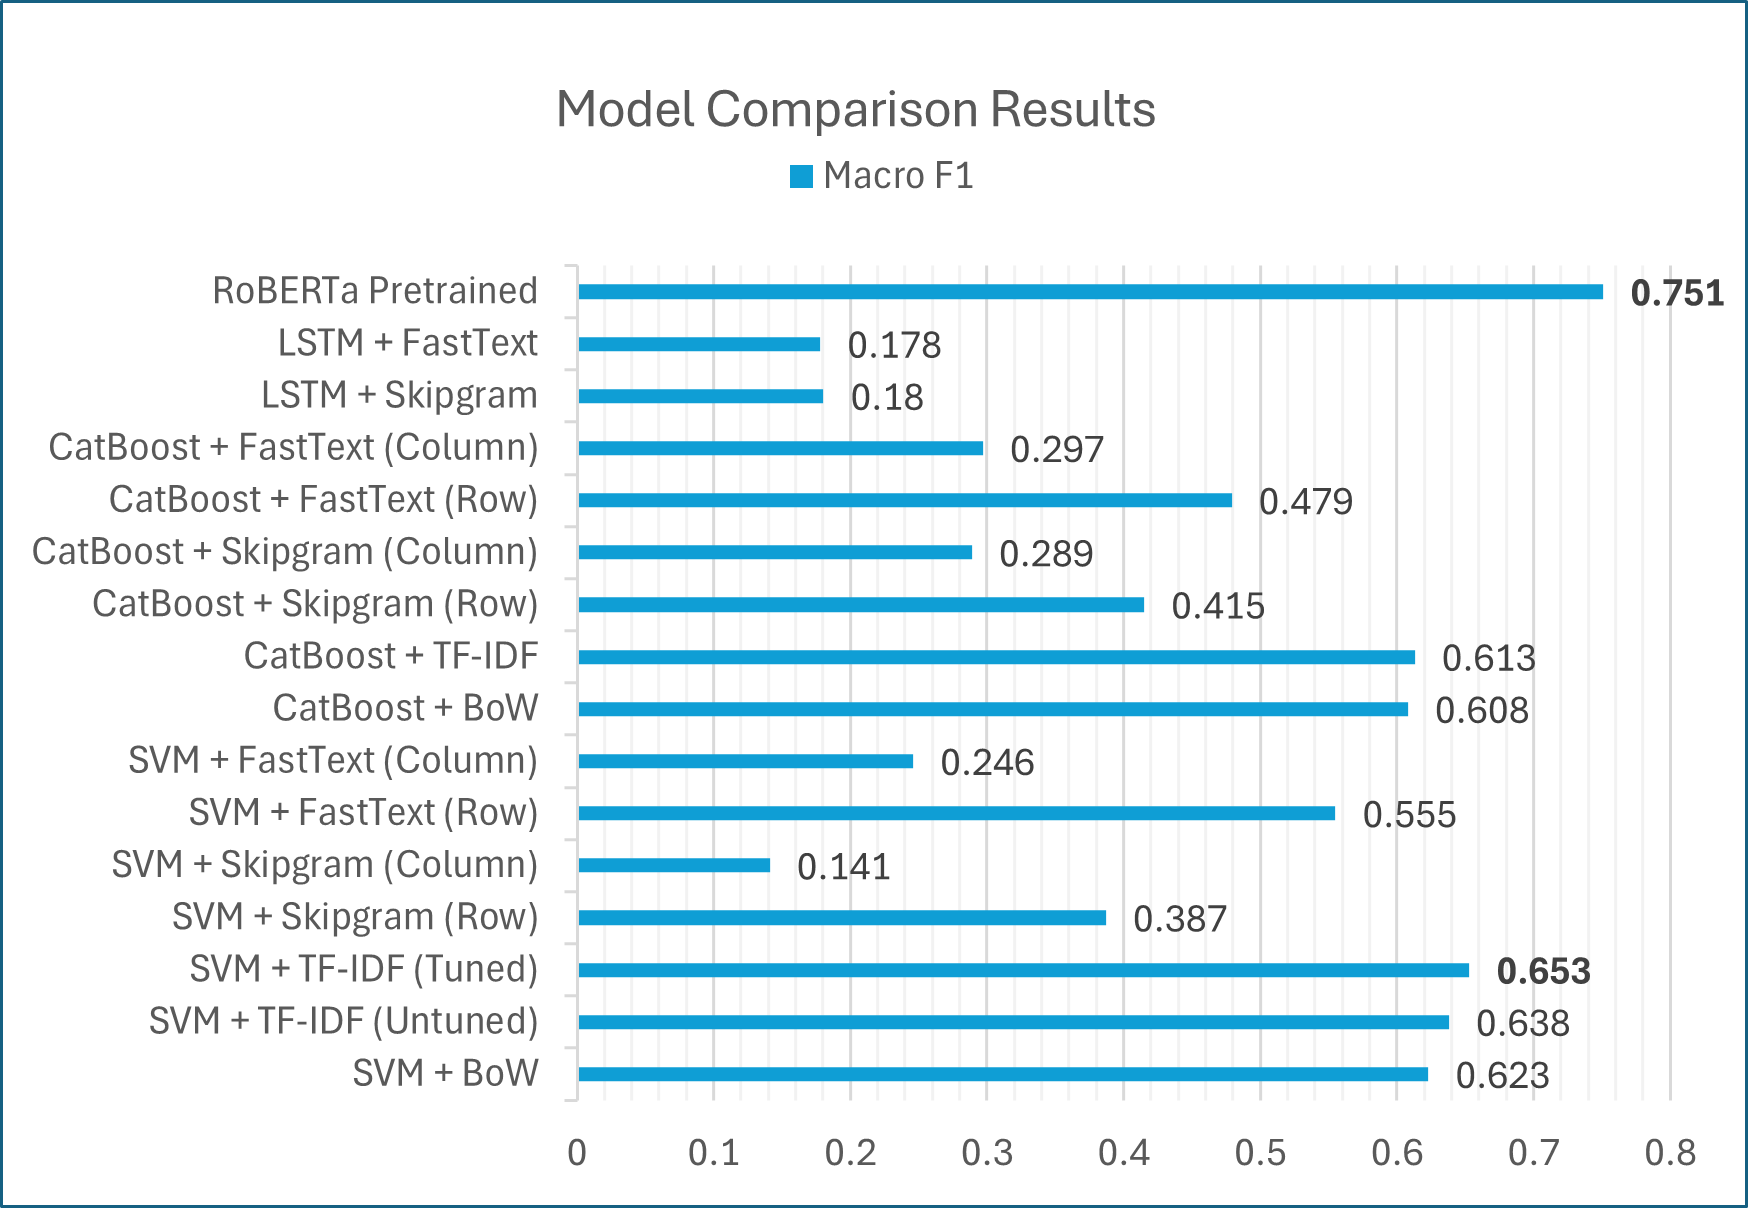